# Wine Quality Classification
Mick Carter

---

In this notebook I will be blah blah blah abstract

## Imports

In [1]:
using CSV, DataFrames, PyPlot, PyCall, StatsBase, ScikitLearn, Statistics, Printf
import ScikitLearn.CrossValidation: train_test_split

sns = pyimport("seaborn")
sns.set_context("notebook")
sns.set_palette("muted")

ENV["COLUMNS"] = 300;

## Load data
Load in red and white wine dataframes, check for the correct number of entries, and combine them into a single dataframe

In [2]:
df_red = CSV.read("winequality-red.csv")
n_red = nrow(df_red)
@assert n_red == 1599

df_white = CSV.read("winequality-white.csv")
n_white = nrow(df_white)
@assert n_white == 4898
@assert names(df_red) == names(df_white)

df = [df_red; df_white]
n_wines = n_red + n_white
(df_red, df_white) = (nothing, nothing)
first(df, 5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
2,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8,5
3,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,5
4,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,6
5,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Visualise data distributions

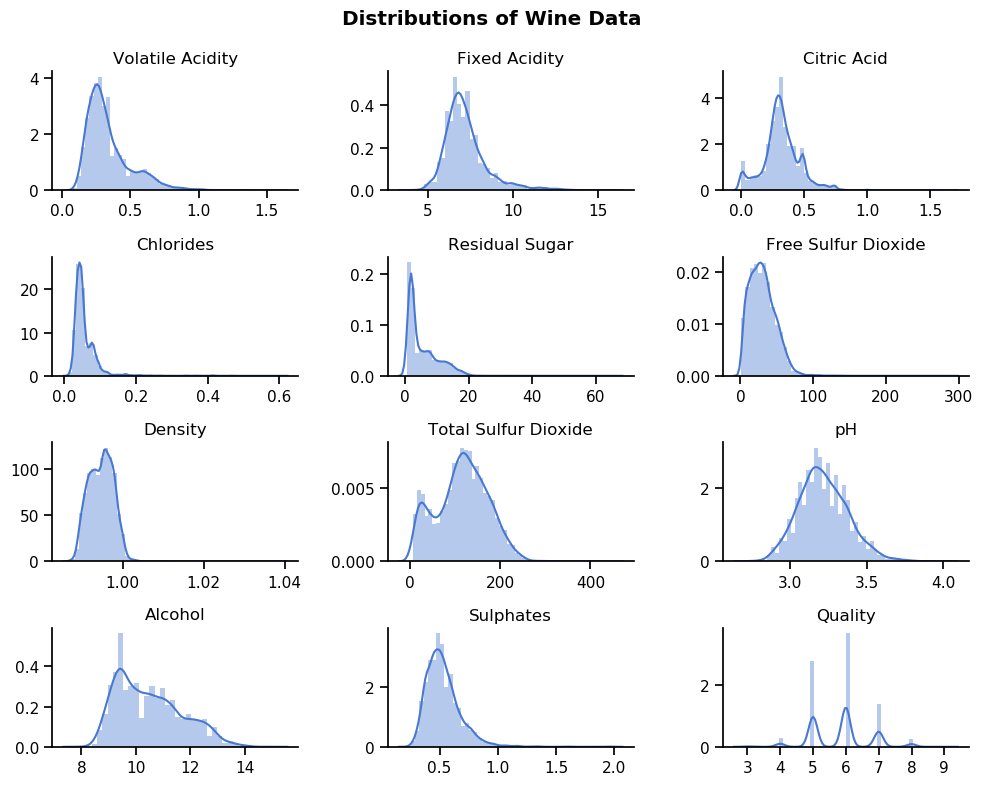

In [3]:
n_col = ncol(df)
plot_cols = 3
fig, ax = subplots(n_col÷plot_cols, plot_cols, figsize=(10, 2*n_col÷plot_cols))
row, col = 0, 0
for (i, key) in enumerate(names(df))
    row = Integer(ceil(i / plot_cols))
    col = plot_cols - i % plot_cols
    sns.distplot(df[!, key], ax=ax[row, col])
    if key == :pH
        key_str = "pH"
    else
        key_str = titlecase(String(key))
    end
    ax[row, col].set_title(key_str)
end
ax[row, col].set_xticks(range(3, stop=9))
fig.suptitle("Distributions of Wine Data", weight="bold")
fig.tight_layout(rect=[0, 0, 1, 0.95])
sns.despine()

## Prepare features and targets for scikit-learn

In [4]:
features = [n for n in names(df) if n != :quality]
n_features = length(features)
X = ones(n_wines, n_features) * NaN
y = df[!, :quality]
for (i, f) in enumerate(features)
    X[:, i] = df[!, f]
end

## Split data
We were asked to provide a parity plot *and* use K-folds cross-validation. A parity plot requires withholding some data, so my plan is to use 90% of the data to tune hyperparameters and train the model, and use the final 10% to build the parity plot.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.9,
    shuffle=true
)
println("Data Separated")
println()
println("test points\t\t", length(X_test))
println("train points\t\t", length(X_train))

Data Separated

test points		7150
train points		64317


## Investigate classification models
I'm taking the shotgun approach at first with a bunch of classifiers I found in the scikit-learn documentation. This is probably advantageous given that we have covered SVC and kNN, but have not had a chance to discuss most of the other models found in this package. In order to give myself an idea of how they perform on this data set, I will evaluate them using `train` and `test` data partitions. These data partitions were intended to be used only for creating parity plots, and perhaps this isn't best practice, but in this case I think it is prudent to do some exploratory fitting. [Here](https://scikit-learn.org/stable/modules/multiclass.html) is a list of inherently multiclass classifiers from the sklearn documentation that I will be investigating.

In [6]:
@sk_import naive_bayes: BernoulliNB
@sk_import tree: DecisionTreeClassifier
@sk_import tree: ExtraTreeClassifier
@sk_import naive_bayes: GaussianNB
@sk_import ensemble: ExtraTreesClassifier
@sk_import neighbors: KNeighborsClassifier
@sk_import semi_supervised: LabelPropagation
@sk_import semi_supervised: LabelSpreading
@sk_import discriminant_analysis: LinearDiscriminantAnalysis
@sk_import svm: LinearSVC
@sk_import neural_network : MLPClassifier
@sk_import neighbors: NearestCentroid
@sk_import discriminant_analysis: QuadraticDiscriminantAnalysis
@sk_import neighbors: RadiusNeighborsClassifier
@sk_import linear_model: RidgeClassifier
@sk_import linear_model: RidgeClassifierCV

classifiers = DataFrame(
    name=[
        "BernoulliNB",
        "DecisionTreeClassifier",
        "ExtraTreeClassifier",
        "GaussianNB",
        "ExtraTreesClassifier",
        "KNeighborsClassifier",
        "LabelPropagation",
        "LabelSpreading",
        "LinearDiscriminantAnalysis",
        "LinearSVC",
        "MLPClassifier",
        "NearestCentroid",
        "QuadraticDiscriminantAnalysis",
        "RadiusNeighborsClassifier",
        "RidgeClassifier",
        "RidgeClassifierCV",
        ],
    cls=[
        BernoulliNB(),
        DecisionTreeClassifier(),
        ExtraTreeClassifier(),
        GaussianNB(),
        ExtraTreesClassifier(),
        KNeighborsClassifier(),
        LabelPropagation(),
        LabelSpreading(),
        LinearDiscriminantAnalysis(),
        LinearSVC(multi_class="crammer_singer"),
        MLPClassifier(),
        NearestCentroid(),
        QuadraticDiscriminantAnalysis(),
        RadiusNeighborsClassifier(radius=100),
        RidgeClassifier(),
        RidgeClassifierCV(),
    ]
)
n_cls = nrow(classifiers)
classifiers[!, :score] = [NaN for _ in 1:n_cls]
for i in 1:n_cls
    cls = classifiers[i, :cls]
    cls.fit(X_train, y_train)
    score = cls.score(X_test, y_test)
    classifiers[i, :score] = score >= 0.0 ? score : NaN
end
filter!(row->!isnan(row[:score]), classifiers)
sort!(classifiers, :score, rev=true);

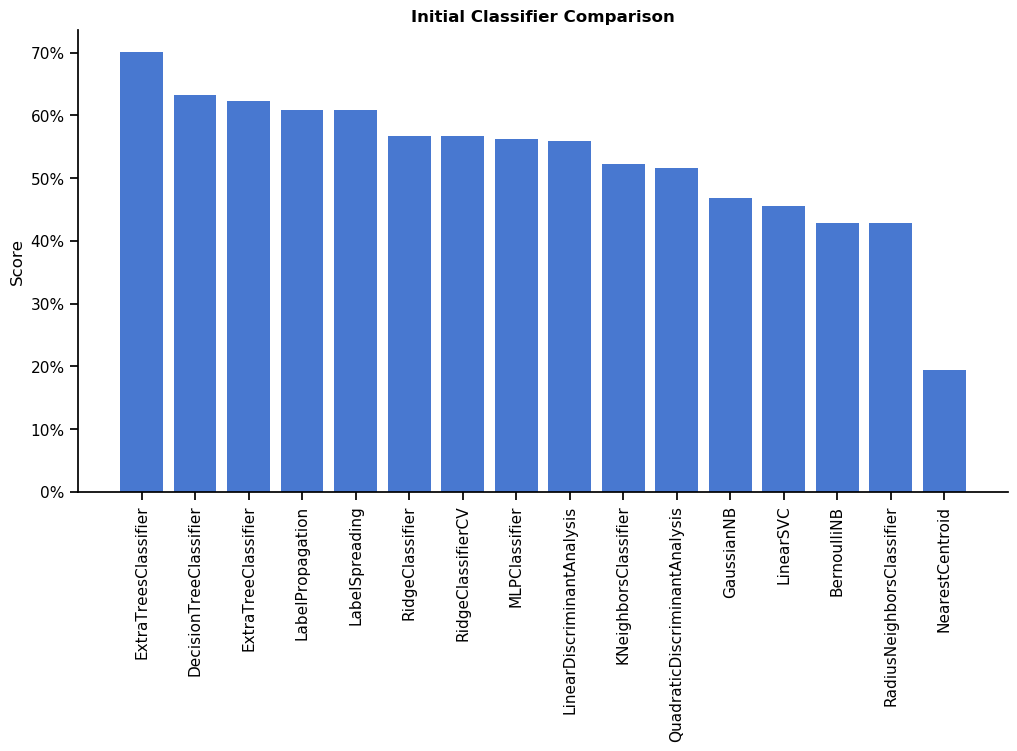

In [7]:
fig, ax = subplots(figsize=(12, 6))
ax.bar(classifiers[!, :name], classifiers[!, :score], color="C0")
ax.set_ylabel("Score")
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(xmax=1.0))
ax.set_title("Initial Classifier Comparison", weight="bold")

xticks(rotation=90)
sns.despine()

Based on this plot, the `ExtraTreesClassifier` seems to be the best choice for this data set. The rest of this analysis will use this classifier.

## Tune hyperparameters and fit model
Since this is a relatively small data set and I am willing to sit here a while, I will be using `GridSearchCV` to find and cross-validate the best hyperparameters for my `ExtraTreesClassifier`. If the training took longer or the parameter space to investigate were larger, I would use `RandomizedSearchCV` to cut down the workload a bit.

According to the [documentation](https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters), the most important parameters for `ExtraTreesClassifier` are `n_estimators` and `max_features`, with suggested values of `None` and `"sqrt"`, respectively. It is also suggested that `max_depth=None` and `min_samples_split=2` often correlate with good results, so all of these values will be included in the grid search.

In [8]:
using ScikitLearn.GridSearch: GridSearchCV
using ScikitLearn: fit!
n_estimators = 10 .^ range(0, stop=3)
max_features = ("auto", "log2", nothing)
min_samples_split = (2, 5, 10, 15)
max_depth = (nothing, 1, 3, 5)

reg = ExtraTreesClassifier(n_jobs=-1)
gsc = GridSearchCV(
    estimator=reg,
    param_grid=Dict(
        :n_estimators => n_estimators,
        :max_features => max_features,
        :min_samples_split => min_samples_split,
        :max_depth => max_depth
    ),
    cv=5,
)
fit!(gsc, X_train, y_train)
cls = ExtraTreesClassifier(
    max_features=gsc.best_params_[:max_features],
    min_samples_split=gsc.best_params_[:min_samples_split],
    n_estimators=gsc.best_params_[:n_estimators],
    max_depth=gsc.best_params_[:max_depth],
    n_jobs=-1
)
cls.fit(X_train, y_train)
@printf("Trained! Estimated accuracy %.2f%%", gsc.best_score_ * 100)

Trained! Estimated accuracy 68.79%

## Results

Because of the discrete nature of the classification, both `hist2d` and `scatter` looked terrible here. I am using violin plots because they show the KDE of predicted qualities at each correct value of wine quality.

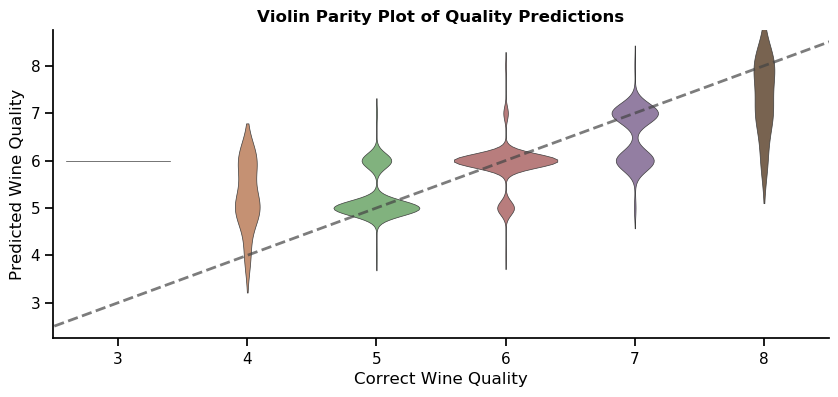

In [10]:
fig, ax = subplots(figsize=(10, 4))
sns.violinplot(
    y_test,
    cls.predict(X_test),
    ax=ax,
    inner=nothing,
    linewidth=0.5,
    saturation=0.5,
    scale="area",
)
ax.plot([-1, 6], [2, 9], color="#444444", alpha=0.7, ls="--", lw=2)
ax.set_xlim([-0.5, 5.5])
ax.set_ylim([2.25, 8.75])
ax.set_xlabel("Correct Wine Quality")
ax.set_ylabel("Predicted Wine Quality")
ax.set_title("Violin Parity Plot of Quality Predictions", weight="bold")
sns.despine()

From this plot we can see that the classification model does a decent job of predicting mid-quality wine, over-predicts low quality wine, and under-predicts high quality wine. This isn't surprising given the distribution of quality data in the training set, which showed the majority of classified wines to be on the interval $(5, 7)$.